In [51]:
import ast
import pandas as pd
pd.set_option('display.max_rows', 50)
import numpy as np
from numpy.ma.core import log10
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

np.random.seed(31415)
Dory_RSSI = [-57,-63,-58,-64,-63,-66]
Dory_RSSI_np = np.array(Dory_RSSI)
df = pd.read_csv('data/raw_data.csv')
df_interpolation = pd.read_csv('data/processed_data.csv')

# Machine Learning Approach
## K-Nearest Neighbors

The ML approaches proposed here struggle to deal with the absence of data from the candidate odd positions. KNN classification approaches may only select as prediction a class that appears in the training dataset and KNN regressors cannot deal with a 2D space.

First we show the behaviour of a naive KNN based on even fingerprints alone. After that, we augment the dataset with the means and intepolations computed in the mathematical approach and try a KNN classification again.

#### K nearest neighbours

We model the localization problem as a multiclass classification problem. We associate to each position a class and to each class al ground truth label. We build the labels with a simple bijective function `(int, int) -> str` based on the `(x,y)` positions of each fingerprint. This creates 36 distinct classes for our 180 fingerprints.

In [52]:
df_kn = df.copy().drop(['exp_id'], axis=1)

# prepend one zero on coordinate label as needed
def my_mapper(x):
    return f"{x:02}"

# add unique ground truth label
df_kn['gt'] = df_kn['X'].map(my_mapper) + df_kn['Y'].map(my_mapper)

# drop X,Y columns, not needed for training
df_kn.drop(["X","Y"], axis=1, inplace=True)

display(df_kn)

,A1,A2,A3,A4,A5,A6,gt
0,-64,-64,-61,-59,-59,-55,1006
1,-60,-60,-57,-55,-55,-51,1006
2,-62,-61,-58,-56,-57,-53,1006
3,-66,-66,-63,-61,-61,-57,1006
4,-64,-64,-61,-59,-59,-55,1006
...,...,...,...,...,...,...,...
175,-59,-61,-54,-55,-57,-56,0804
176,-66,-67,-61,-60,-63,-63,0804
177,-64,-65,-59,-58,-61,-61,0804
178,-65,-66,-60,-59,-62,-62,0804


We split the dataset 80/20 with stratified sampling. This ensures that exactly one sample of each class is present in the test set and four samples of each class are present in the training set.

In [53]:
scaler = StandardScaler()

Y = df_kn['gt']
X = df_kn.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.2, stratify=Y)

assert len(y_test) == 36

display(X_train[0])

array([-0.86634589, -1.0373262 , -0.17858305,  0.43651794, -1.2875297 ,
       -0.93457458])

We fix the random seed for reproducibility of our results. As seen in class, we train many KNN classifiers and select the one with best accuracy. We also plot the confusion matrix of the best classifier.

0.7222222222222222
0.7222222222222222
0.6388888888888888
0.6388888888888888
0.6111111111111112
0.6388888888888888
0.6111111111111112
0.6388888888888888
0.6388888888888888


Text(0, 0.5, 'Accuracy')

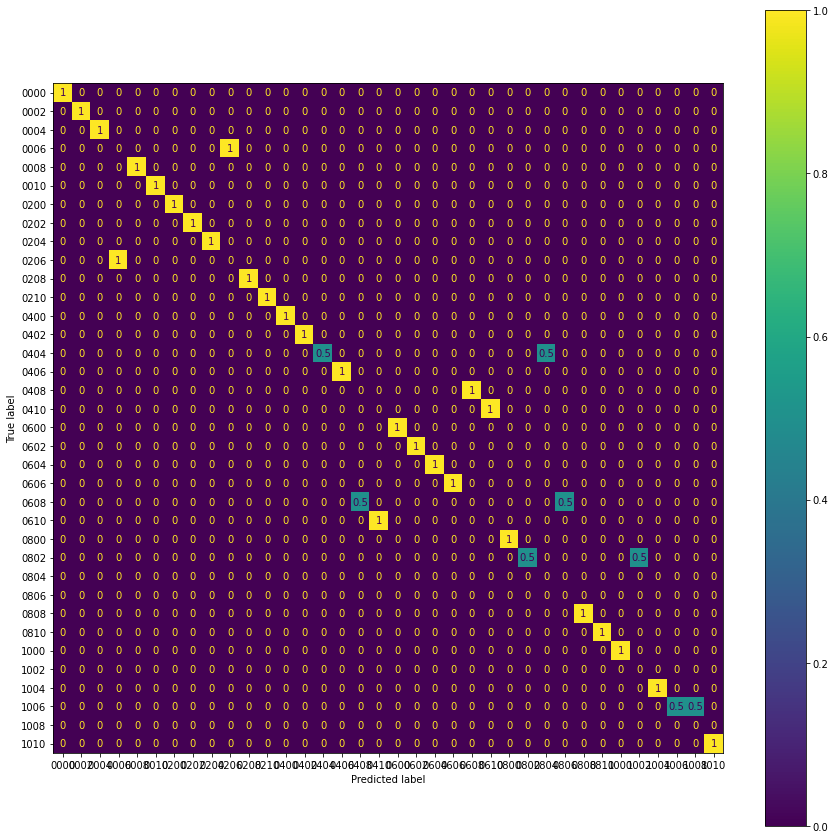

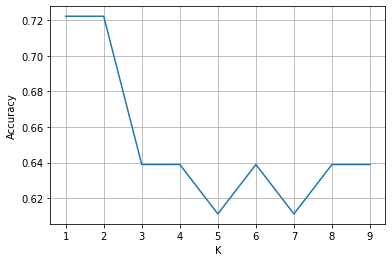

In [54]:
ACCURACY = []
for k in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')

fig = plt.figure()
plt.plot(range(1,10),ACCURACY)
plt.grid()
plt.xlabel('K')
plt.ylabel('Accuracy')

The matrix above shows that our model offers results better than random guessing. The accuracy plot shows that the best results are obtained for `k = 1,2` and accuracy quickly degrades for values > 2.

In [55]:
knn.predict(Dory_RSSI_np.reshape(-1,6))

array(['0206'], dtype=object)

This model selects the positon **(2,6)**. This model should not be trusted.

### KNN with interpolations

To deal with missing data, we attempt to train a model over the data set of averages alone. This guarantees exactly one sample per position. This is bad from a theoretical ML perspective: after train/test split, some classes will have no representatives in the train or in the test set. Stratified sampling is also impossible.

In [56]:
df_kni = df_interpolation.copy()

# prepend one zero on coordinate label as needed
def my_mapper(x):
    return f"{int(x):02}"

# add unique ground truth label
df_kni['gt'] = df_kni['X'].map(my_mapper) + df_kni['Y'].map(my_mapper)

# drop X,Y columns, not needed for training
df_kni.drop(["X","Y"], axis=1, inplace=True)

display(df_kni)

,A1,A2,A3,A4,A5,A6,gt
0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8,0000
1,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4,0002
2,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0,0004
3,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4,0006
4,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0,0008
...,...,...,...,...,...,...,...
116,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5,1001
117,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8,1003
118,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0,1005
119,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6,1007


0.7222222222222222
0.7222222222222222
0.6388888888888888
0.6388888888888888
0.6111111111111112
0.6388888888888888
0.6111111111111112
0.6388888888888888
0.6388888888888888


Text(0, 0.5, 'Accuracy')

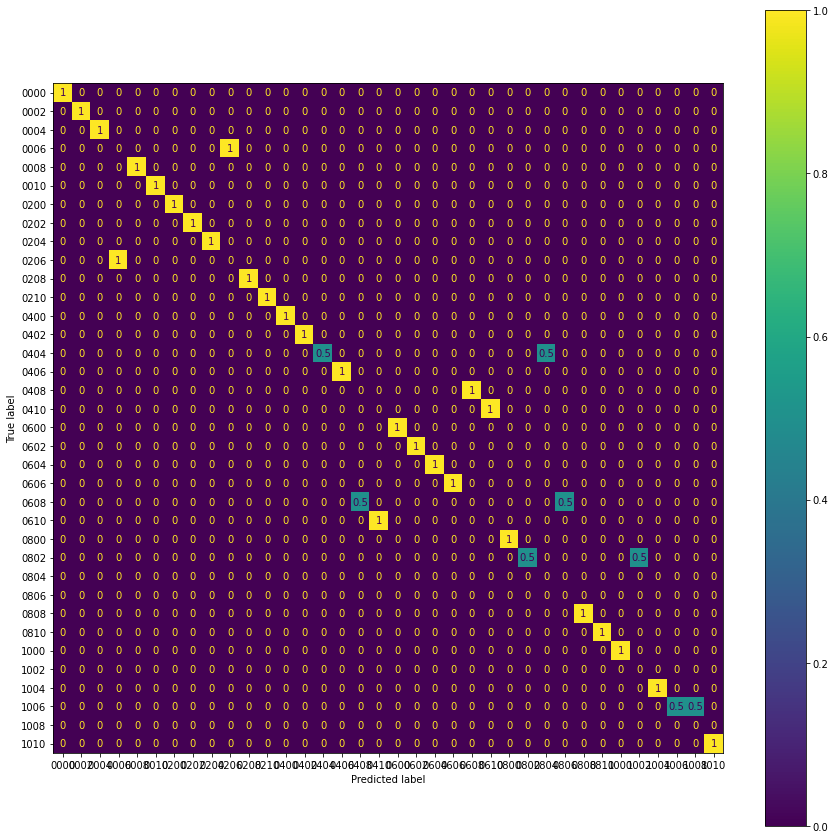

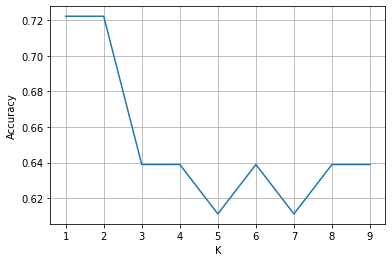

In [57]:
ACCURACY = []
for k in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')

fig = plt.figure()
plt.plot(range(1,10),ACCURACY)
plt.grid()
plt.xlabel('K')
plt.ylabel('Accuracy')

The confusion matrix shows a critical flaw of this model: some positions do not appear as classification output. This is because they were selected for the test set and now cannot be present in the training set, from which classes are built. The same rapid drop in accuracy seen befire is shown.

In [58]:
knn.predict(Dory_RSSI_np.reshape(-1,6))

array(['0206'], dtype=object)

This model selects the position **(2,6)**. This model should not be trusted.

#### KNN fingerprints + interpolations

Now we try to use all data, original and augmented together, to train a finer KNN classifier able to identify both even and odd positions. This is once again not conform to ML theory, as some classes (odd positions) only have one sample in the original dataset, which exposes us to the same problem seen before. Furthermore, we introduce unbalance between representatives of different classes which is not relevant to the localization task.

In [59]:
df_knfi = df.copy().drop(['exp_id'], axis=1)
df_knfi = pd.concat([df_knfi, df_interpolation])

# prepend one zero on coordinate label as needed
def my_mapper(x):
    return f"{int(x):02}"

# add unique ground truth label
df_knfi['gt'] = df_knfi['X'].map(my_mapper) + df_knfi['Y'].map(my_mapper)

# drop X,Y columns, not needed for training
df_knfi.drop(["X","Y"], axis=1, inplace=True)

display(df_knfi)

,A1,A2,A3,A4,A5,A6,gt
0,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0,1006
1,-60.0,-60.0,-57.0,-55.0,-55.0,-51.0,1006
2,-62.0,-61.0,-58.0,-56.0,-57.0,-53.0,1006
3,-66.0,-66.0,-63.0,-61.0,-61.0,-57.0,1006
4,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0,1006
...,...,...,...,...,...,...,...
116,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5,1001
117,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8,1003
118,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0,1005
119,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6,1007


In [60]:
scaler = StandardScaler()

Y = df_knfi['gt']
X = df_knfi.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.3)

display(len(y_test.unique()))
display(y_train)

61

105    0709
151    1002
101    0002
13     0402
177    0804
       ... 
70     0602
100    0609
56     0808
116    1001
0      0000
Name: gt, Length: 210, dtype: object

0.4065934065934066
0.4065934065934066
0.4065934065934066
0.38461538461538464
0.3626373626373626
0.3626373626373626
0.37362637362637363
0.3626373626373626
0.3626373626373626
0.3626373626373626
0.34065934065934067
0.3516483516483517
0.34065934065934067
0.34065934065934067
0.34065934065934067
0.3516483516483517
0.3516483516483517
0.3516483516483517
0.34065934065934067
0.34065934065934067


Text(0, 0.5, 'Accuracy')

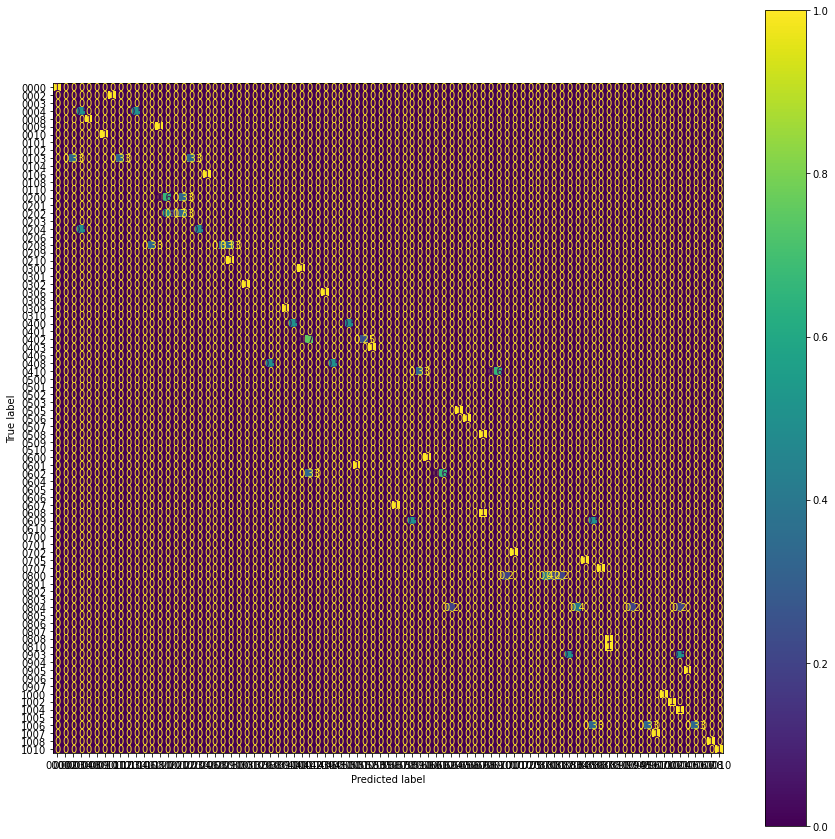

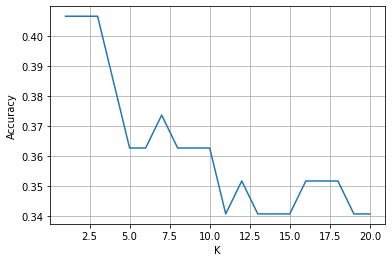

In [61]:
ACCURACY = []
MAX_K = 20 + 1

for k in range(1,MAX_K):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance', p=2)
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')

fig = plt.figure()
plt.plot(range(1,MAX_K),ACCURACY)
plt.grid()
plt.xlabel('K')
plt.ylabel('Accuracy')

In [62]:
knn.predict(Dory_RSSI_np.reshape(-1,6))

array(['0206'], dtype=object)

This model selects the position **(2,6)**. This model should not be trusted.

#### experiment-based interpolation and KNN

Anotehr approach to deal with scarcity of data in odd positions is to consider each experiment in the even positions and for each experiment interpolate all missing odd positions for that experiment. This produces a larger dataset of `605=11*11*5` data points, which may be better suited for ML applications.

After computing the new dataset, we proced to apply KNN like before.

In [63]:
# row-based
df_ei = df.copy()

for exp_id in range(5):
    for x in range(1,10,2):
        for y in range(0,11,2):
            row = pd.DataFrame(df_ei.loc[ ( (df_ei['X'] == (x - 1)) |
                                            (df_ei['X'] == (x + 1))) &
                                            (df_ei['Y'] == y)        
                                            #&(df_ei['exp_id'] == exp_id)
                                            &(df_ei['exp_id'] == exp_id)
                                            ].mean(axis=0).dropna()).transpose()
            df_ei = pd.concat([df_ei, row])

    # column-based
    for x in range(0,11,1):
        for y in range(1,10,1):

            if not df_ei.loc[(df_ei['X'] == x) &
                                (df_ei['Y'] == y)
                                &(df_ei['exp_id'] == exp_id)
                                ].empty:
                continue
            row = pd.DataFrame(df_ei.loc[(  (df_ei['Y'] == (y - 1)) |
                                            (df_ei['Y'] == (y + 1))) &
                                            (df_ei['X'] == x)
                                            &(df_ei['exp_id'] == exp_id)
                                            ].mean(axis=0).dropna()).transpose()
            df_ei = pd.concat([df_ei, row])

display(df_ei)

,X,Y,exp_id,A1,A2,A3,A4,A5,A6
0,10.0,6.0,0.0,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0
1,10.0,6.0,1.0,-60.0,-60.0,-57.0,-55.0,-55.0,-51.0
2,10.0,6.0,2.0,-62.0,-61.0,-58.0,-56.0,-57.0,-53.0
3,10.0,6.0,3.0,-66.0,-66.0,-63.0,-61.0,-61.0,-57.0
4,10.0,6.0,4.0,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0
...,...,...,...,...,...,...,...,...,...
0,10.0,1.0,4.0,-63.0,-65.5,-58.0,-36.5,-63.5,-62.0
0,10.0,3.0,4.0,-67.0,-68.0,-62.0,-56.0,-65.5,-63.5
0,10.0,5.0,4.0,-67.5,-67.5,-63.5,-60.5,-63.5,-60.5
0,10.0,7.0,4.0,-66.5,-65.5,-63.5,-62.0,-60.0,-54.0


In [64]:
df_kn = df_ei.copy().drop(['exp_id'], axis=1)

# prepend one zero on coordinate label as needed
def my_mapper(x):
    return f"{int(x):02}"

# add unique ground truth label
df_kn['gt'] = df_kn['X'].map(my_mapper) + df_kn['Y'].map(my_mapper)

# drop X,Y columns, not needed for training
df_kn.drop(["X","Y"], axis=1, inplace=True)

display(df_kn)

,A1,A2,A3,A4,A5,A6,gt
0,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0,1006
1,-60.0,-60.0,-57.0,-55.0,-55.0,-51.0,1006
2,-62.0,-61.0,-58.0,-56.0,-57.0,-53.0,1006
3,-66.0,-66.0,-63.0,-61.0,-61.0,-57.0,1006
4,-64.0,-64.0,-61.0,-59.0,-59.0,-55.0,1006
...,...,...,...,...,...,...,...
0,-63.0,-65.5,-58.0,-36.5,-63.5,-62.0,1001
0,-67.0,-68.0,-62.0,-56.0,-65.5,-63.5,1003
0,-67.5,-67.5,-63.5,-60.5,-63.5,-60.5,1005
0,-66.5,-65.5,-63.5,-62.0,-60.0,-54.0,1007


In [65]:
scaler = StandardScaler()

Y = df_kn['gt']
X = df_kn.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=1./5., stratify=Y)

print(len(y_test.unique()))

121


0.6198347107438017
0.6198347107438017
0.5785123966942148
0.5867768595041323
0.5454545454545454
0.5537190082644629
0.5289256198347108
0.5289256198347108
0.5206611570247934
0.5289256198347108
0.5041322314049587
0.48760330578512395
0.5041322314049587
0.49586776859504134
0.49586776859504134
0.48760330578512395
0.49586776859504134
0.48760330578512395
0.49586776859504134
0.49586776859504134


Text(0, 0.5, 'Accuracy')

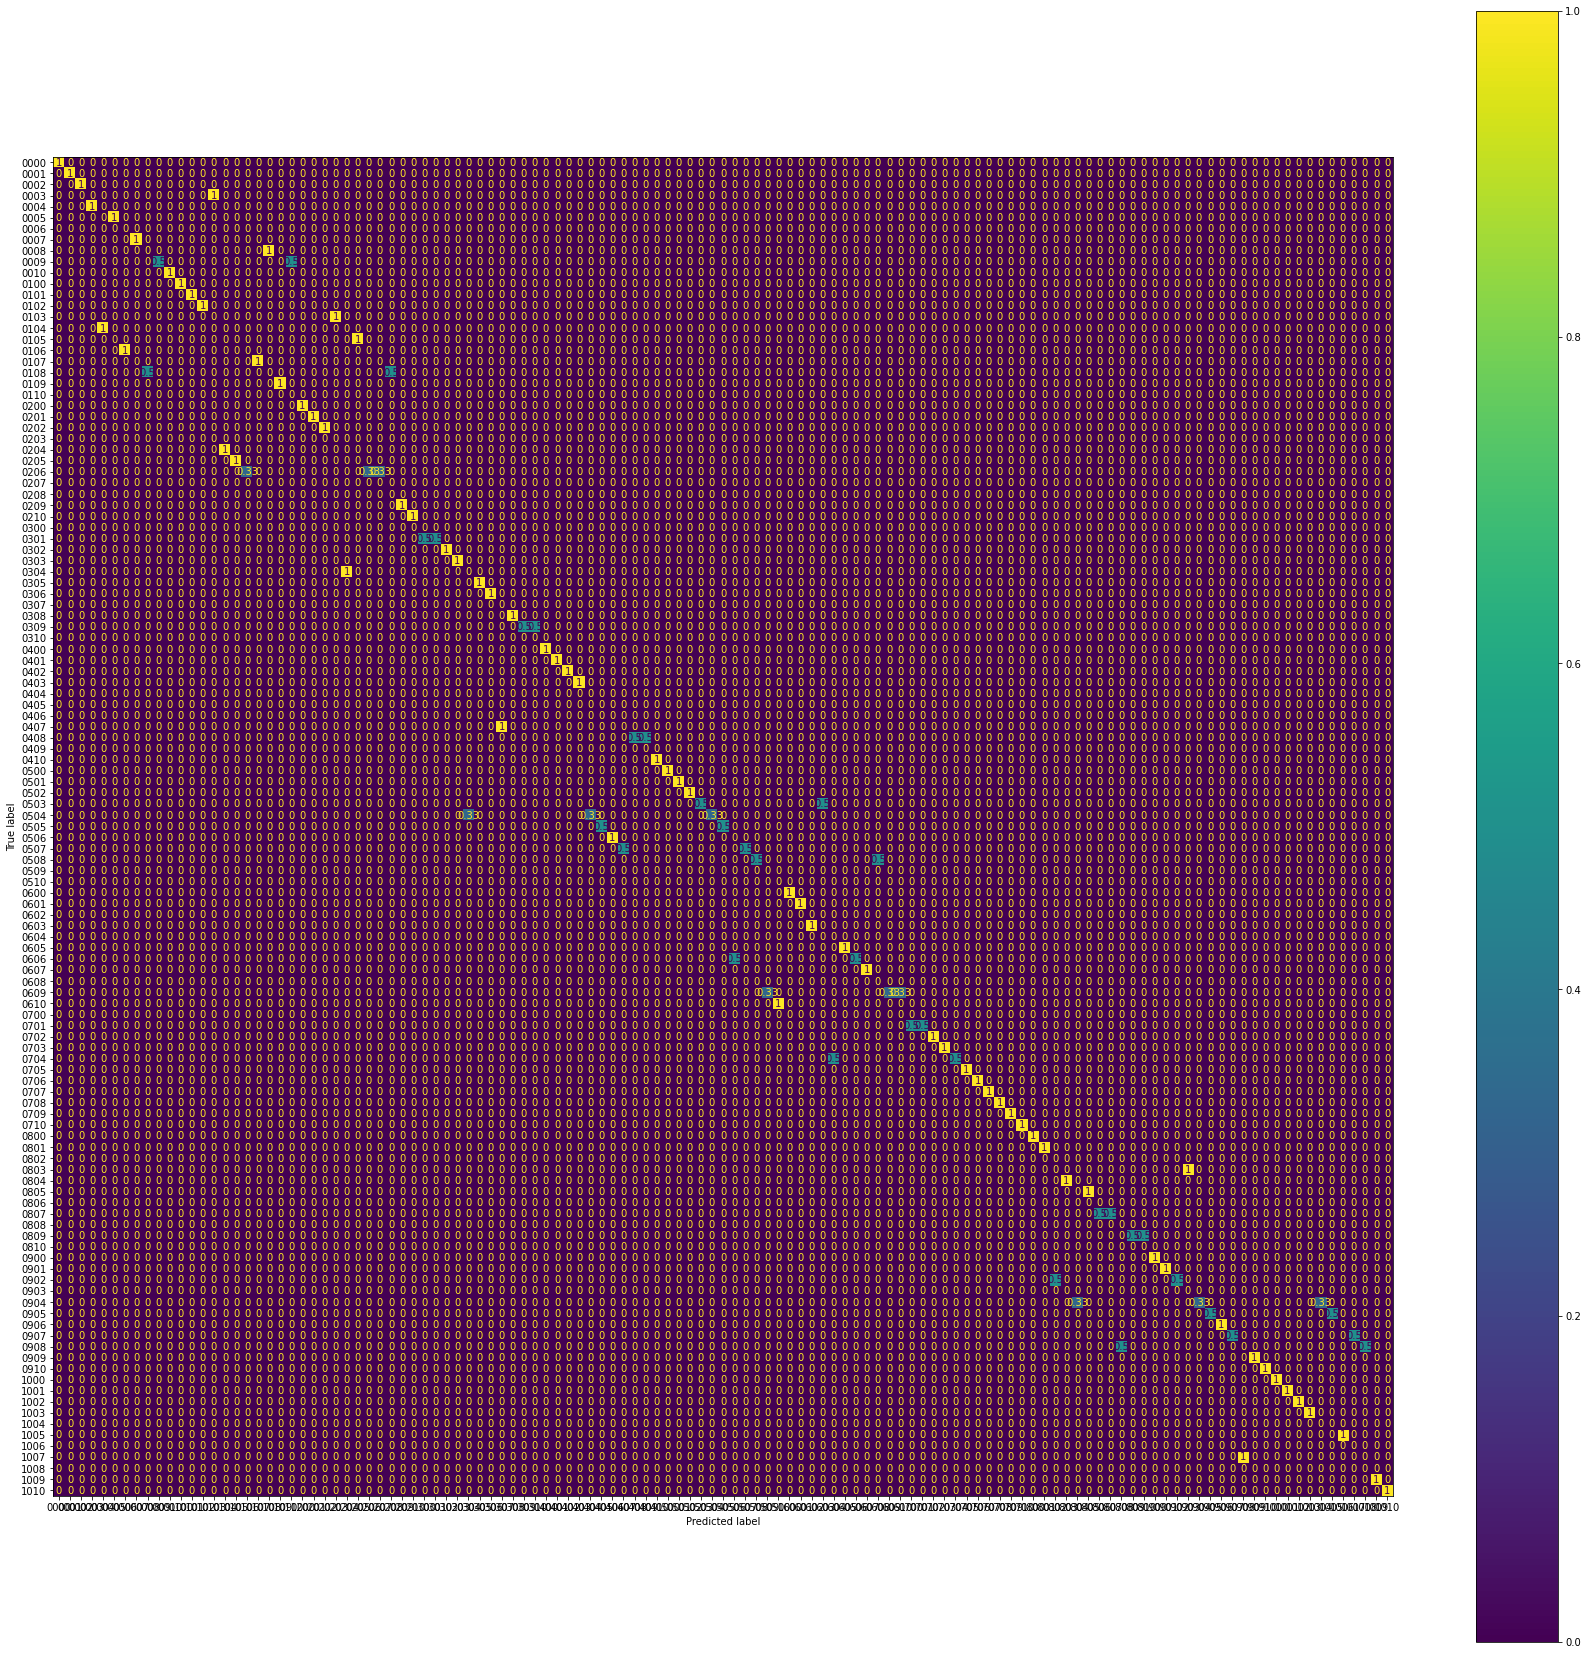

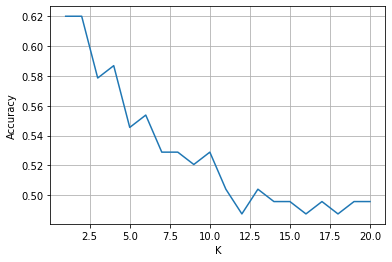

In [66]:
ACCURACY = []
MAX_K = 20 + 1

for k in range(1,MAX_K):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance', p=2)
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(30, 30))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')

fig = plt.figure()
plt.plot(range(1,MAX_K),ACCURACY)
plt.grid()
plt.xlabel('K')
plt.ylabel('Accuracy')

In [67]:
knn.predict(Dory_RSSI_np.reshape(-1,6))

array(['0206'], dtype=object)

## KNN Variant
Since the attempted KNN approach is not giving satisfactory results mostly because of data scarcity, we attempted a different technique that resembles KNN. In particular we choose to replicate the KNN approach but instead of splitting the dataset to employ a standard machine learning technique, we choose to use the whole dataset for the testing part of the process.

In [68]:
scaler = StandardScaler()

Y = df_kni['gt']
X = df_kni.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)
X_train, y_train = X, Y

display(X_train)

,A1,A2,A3,A4,A5,A6
0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
...,...,...,...,...,...,...
116,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5
117,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8
118,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0
119,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6


In [69]:
dory_predictions = []
for k in range(1,20):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2)
  knn.fit(X_train, y_train)
  pred = knn.predict(Dory_RSSI_np.reshape((-1,6)))
  dory_predictions.append((k, pred))
for i in range(1, 20):
  print(f"k = %s: (%s,%s)" % (
    dory_predictions[i-1][0],
    dory_predictions[i-1][1][0][0:2],
    dory_predictions[i-1][1][0][2:4]
  ))

k = 1: (02,03)
k = 2: (02,03)
k = 3: (02,03)
k = 4: (02,03)
k = 5: (02,03)
k = 6: (02,03)
k = 7: (02,03)
k = 8: (02,03)
k = 9: (02,03)
k = 10: (02,03)
k = 11: (02,03)
k = 12: (02,03)
k = 13: (02,03)
k = 14: (02,03)
k = 15: (02,03)
k = 16: (02,03)
k = 17: (02,03)
k = 18: (02,03)
k = 19: (02,03)


This type of approach, even if not technically correct from a machine learning point of view, does corroborate the results of the pure mathematical approach.